# Laboratorio 4

Si richiede un'implementazione di un sistema di text segmentation, prendendo ispirazione da TextTiling. In particolare, partendo da un corpus composto da almeno 3 sezioni su tematiche molto diverse (ad es. potete usare paragrafi da tre pagine di Wikipedia diverse), dovrete testare il vostro sistema in modo che riesca ad individuare le giuste linee di taglio (o quasi).

Si procederà in 4 passi

1. Separazione del testo in finestre di lunghezza fissa

2. Calcolo della coesione intra-gruppo: il valore di coesione è semplicemente quanto si usano le stesse parole tra blocchi successivi di frasi (o tokens). Facendo il plot di questo valore all’interno delle finestre si ottengono dei picchi, che possono essere usati per modificare  successivamente le finestre

3. Ricerca di parti di testo a bassa coesione circondate da parti di testo ad alta coesione. I picchi più importanti sono quelli verso il basso: sono proprio le parti di testo a bassa coesione circondate da parti di testo ad alta coesione. Vengono anche chiamati break points

4. Riadattamento delle finestre rispetto al break point più
vicino: alla fine si ottiene qualcosa di simile a quanto
mostrato in figura

In [37]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


In [38]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clear_sentence(sentence):
    tokens = nltk.word_tokenize(sentence)
    tokens = [token for token in tokens if token not in string.punctuation] #tolgo la punteggiatura
    tokens = [token.lower() for token in tokens] # sostituisco le maiuscole con le minuscole
    tokens = [token for token in tokens if token not in stop_words] # rimuovo le stop words
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # lemmatizzo
    
    return tokens

In [39]:
class Frase:
    # ============================================
    # Constructor
    # ============================================
    def __init__(self, id, sentence, clear_sentence):
        self.id = id
        self.sentence = sentence
        self.clear_sentence = clear_sentence
        self.words_count = self._compute_words_count()

    def __str__(self):
        return "Frase " + self.id

    # ============================================
    # Private methods
    # ============================================    
    def _compute_words_count(self):
        words_count = {}
        for word in self.clear_sentence:
            if word in words_count:
                words_count[word] += 1
            else:
                words_count[word] = 1
        return words_count
    
    # ============================================
    # Public methods
    # ============================================

In [40]:
class ListaFrasi:
    # ============================================
    # Constructor
    # ============================================
    def __init__(self, frasi):
        self.frasi = frasi

        self.breakpoints = []
        self.similarity_values = []
        self.k = 0

        self.best_breakpoints = []
        self.best_evaluation = 0
        self.best_similarity_values = []

    def __str__(self):
        return "Contenitore con " + str(len(self.frasi)) + " frasi"
    
    # ============================================
    # Accessors
    # ============================================
    def get_frase(self):
        return self.frasi
    
    def set_frase(self, frasi):
        self.frasi = frasi
    
    # ============================================
    # Private methods
    # ============================================

    '''
    Calcolo della coesione tra frasi successive
    '''
    def _cohesion(self, frase1, frase2):
        coesione = 0

        for token in frase1.words_count.keys():
            if token in frase2.words_count.keys():
                coesione += int(frase1.words_count[token]) + int(frase2.words_count[token])
                #print('coesione += ' + token + '(',str(frase1.words_count[token]) + ') + ' + token, '(',str(frase2.words_count[token]) + ') = ' + str(coesione))

        return coesione

    def _check_cluster_dimension(self, cluster):
        if (len(cluster) <= 2):
            print('ATTENZIONE: cluster di lunghezza <= 2')
            return False
        return True
    
    '''
    Calcolo della coesione tra frasi successive
    '''
    def _get_choesions(self):
        similarity_values = []
        start = -1

        for i in range(len(self.breakpoints)):
            cluster = {}
            start += 1
            while start + 1 < self.breakpoints[i]:
                #print('(' + str(start) + ',' + str(start+1) + ')')
                cluster[(start, start+1)] = self._cohesion(self.frasi[start], self.frasi[start+1])
                #print('\n')
                start += 1
            similarity_values.append(cluster)

        self.similarity_values = similarity_values

        self.plot_coehesion_values()          
        print('COESIONE: ', similarity_values)
        print('BREAKPOINTS: ', self.breakpoints)
        self._evaluate_breakpoints()
    
    '''
    calcolo il numero di parole medie in comune per ogni cluster
    '''
    def _evaluate_breakpoints(self):
        eval = 0
        for cluster in self.similarity_values:
            eval = sum(cluster.values())/len(cluster)

        eval = eval/len(self.similarity_values)
        print('N. PAROLE MEDIE PER CLUSTER', eval)

        if (eval > self.best_evaluation):
            self.best_evaluation = eval
            self.best_breakpoints = self.breakpoints.copy()
            self.best_similarity_values = self.similarity_values.copy()

    # ============================================
    # Public methods
    # ============================================
    '''
    Plotto le coesioni tra frasi successive
    '''
    def plot_coehesion_values(self, best = False):
        #genero k colori
        colors = []
        for i in range(self.k):
            colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))    

        if (best):
            data = self.best_similarity_values
        else:
            data = self.similarity_values        

        for i, d in enumerate(data):
            x = [key[0] for key in d.keys()]
            y = list(d.values())

            plt.plot(x, y, marker='o', color=colors[i], label=f'cluster {i+1}')

        plt.xlabel('Coppie di frasi')
        plt.ylabel('Numero di parole in comune')
        plt.title('Coesione tra frasi successive')

        plt.legend()
        plt.show()

    '''
    Ritorna una frase dato il suo id, None se non esiste
    '''
    def get_frase_by_id(self, id):
        for frase in self.frasi:
            if frase.id == str(id):
                return frase
        return None

    '''
    Genera 3 numeri random da mettere self.breakpoints con il vincolo che tra un numero 
    e l'altro ci siano almeno 2 numeri di differenza
    '''
    def generate_initial_breakpoints(self, k):
        self.k = k
        num_sentences = len(self.frasi)
        self.breakpoints = [(num_sentences // k)*i for i in range(1,k)]
        self.breakpoints = list(np.insert(self.breakpoints, len(self.breakpoints), len(self.frasi)-1))

        print('BREAKPOINTS: ', self.breakpoints)
        self._get_choesions()

    def search_new_breakpoints(self):
        liste_minimi = {}
        i = 0
        for similarity in self.similarity_values:
            min_value = min(similarity.values())
            min_keys = [key for key in similarity.keys() if similarity[key] == min_value]
            if (len(similarity) < 2):
                print('ATTENZIONE: cluster con meno di 2 frasi')
                liste_minimi[i] = (min_keys, min_value, False) #posizioni, valore minimo, usabile
            else:
                liste_minimi[i] = (min_keys, min_value, True)
            i += 1
    
        print('LISTE DI MINIMI: ', liste_minimi)

        new_breakpoints = []
        j = 0
        while j < len(liste_minimi)-1:
            minimo1 = liste_minimi[j]
            minimo2 = liste_minimi[j+1]

            if minimo1[2] and minimo2[2]:
                print('a',  minimo1[1], '> ', minimo2[1])
                if minimo1[1] > minimo2[1]:
                    print('a.1')
                    random_index = 0
                    if (len(minimo2[0]) > 1):
                        random_index = np.random.randint(0, len(minimo2[0]))

                    print('1.a', len(minimo2[0]), random_index)

                    new_breakpoints.append(minimo2[0][random_index][0])
                    liste_minimi[j+1] = (minimo2[0], minimo2[1], False)
                else:
                    print('a.2')
                    random_index = 0

                    if (len(minimo1[0]) > 1):
                        random_index = np.random.randint(0, len(minimo1[0]))
                        
                    print('1.b', len(minimo1[0]), random_index)

                    new_breakpoints.append(minimo1[0][random_index][1])
                    liste_minimi[j] = (minimo1[0], minimo1[1], False)
            elif minimo1[2]:
                print('b')
                random_index = 0
                if (len(minimo1[0]) > 1):
                    random_index = np.random.randint(0, len(minimo1[0]))

                print('2', len(minimo1[0]), random_index)
                new_breakpoints.append(minimo1[0][random_index][1])
                liste_minimi[j] = (minimo1[0], minimo1[1], False)
            else: # minimo2[2]:
                print('c')
                random_index = 0
                if (len(minimo2[0]) > 1):
                    random_index = np.random.randint(0, len(minimo2[0]))

                print('3', len(minimo2[0]), random_index)
                new_breakpoints.append(minimo2[0][random_index][0])
                liste_minimi[j+1] = (minimo2[0], minimo2[1], False)
           
            print('j: ',j,'-', new_breakpoints)
            j += 1

        if (1 in new_breakpoints):
            self.search_new_breakpoints()
            return

        new_breakpoints.append(len(self.frasi)-1)
        print('NEW BREAKPOINTS: ', new_breakpoints)
        self.breakpoints = new_breakpoints

        self._get_choesions()  

## Main

### Estraggo le frasi e le metto nell'oggetto Contenitore

In [41]:
sentences = pd.read_csv('data/corpus.csv')['sentence']

# Creo un oggetto Frase per ogni frase del corpus
frasi = []
for i in range(len(sentences)):
    frasi.append(Frase(str(i+1), sentences[i], clear_sentence(sentences[i])))

# Creo un oggetto Contenitore che contiene tutte le frasi
contenitore = ListaFrasi(frasi)

### Separazione del testo in k finistre di lunghezza fissa

BREAKPOINTS:  [10, 20, 30]


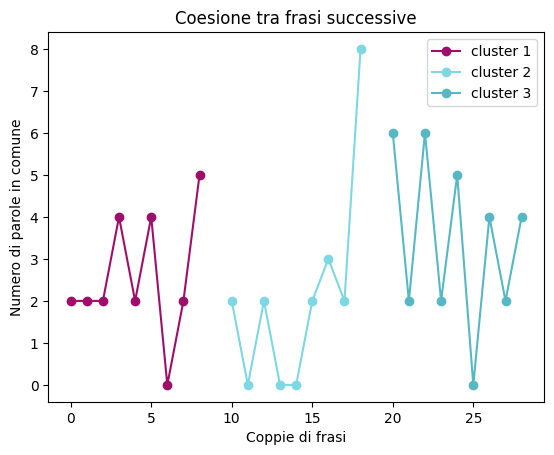

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5}, {(10, 11): 2, (11, 12): 0, (12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8}, {(20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [10, 20, 30]
N. PAROLE MEDIE PER CLUSTER 1.1481481481481481


In [42]:
contenitore.generate_initial_breakpoints(k=3)

### Fase di iterzione

Calcolo la coesione intra-gruppo e ricalcolo da ciò i breakpoint

LISTE DI MINIMI:  {0: ([(6, 7)], 0, True), 1: ([(11, 12), (13, 14), (14, 15)], 0, True), 2: ([(25, 26)], 0, True)}
a 0 >  0
a.2
1.b 1 0
j:  0 - [7]
a 0 >  0
a.2
1.b 3 0
j:  1 - [7, 12]
NEW BREAKPOINTS:  [7, 12, 30]


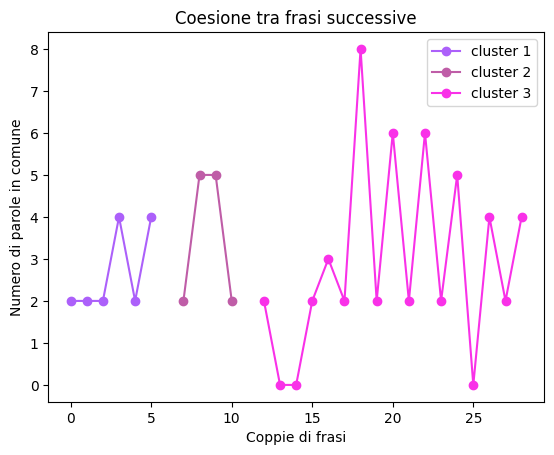

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4}, {(7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2}, {(12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [7, 12, 30]
N. PAROLE MEDIE PER CLUSTER 0.9803921568627452


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3), (4, 5)], 2, True), 1: ([(7, 8), (10, 11)], 2, True), 2: ([(13, 14), (14, 15), (25, 26)], 0, True)}
a 2 >  2
a.2
1.b 4 2
j:  0 - [3]
a 2 >  0
a.1
1.a 3 0
j:  1 - [3, 13]
NEW BREAKPOINTS:  [3, 13, 30]


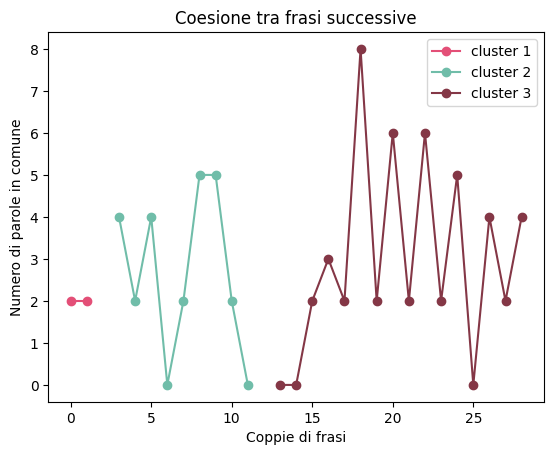

COESIONE:  [{(0, 1): 2, (1, 2): 2}, {(3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0}, {(13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [3, 13, 30]
N. PAROLE MEDIE PER CLUSTER 1.0


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2)], 2, True), 1: ([(6, 7), (11, 12)], 0, True), 2: ([(13, 14), (14, 15), (25, 26)], 0, True)}
a 2 >  0
a.1
1.a 2 0
j:  0 - [6]
c
3 3 2
j:  1 - [6, 25]
NEW BREAKPOINTS:  [6, 25, 30]


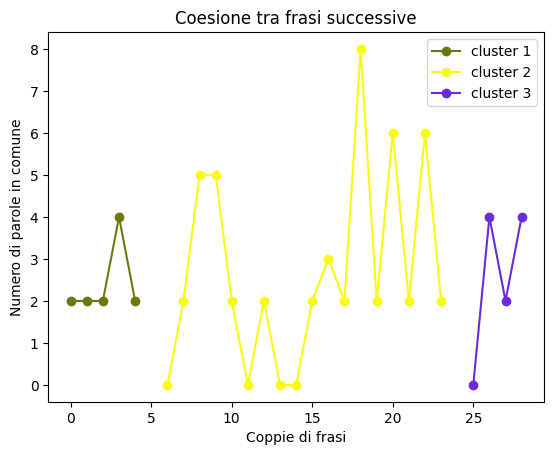

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2}, {(6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0, (12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2}, {(25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [6, 25, 30]
N. PAROLE MEDIE PER CLUSTER 0.8333333333333334


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3), (4, 5)], 2, True), 1: ([(6, 7), (11, 12), (13, 14), (14, 15)], 0, True), 2: ([(25, 26)], 0, True)}
a 2 >  0
a.1
1.a 4 1
j:  0 - [11]
c
3 1 0
j:  1 - [11, 25]
NEW BREAKPOINTS:  [11, 25, 30]


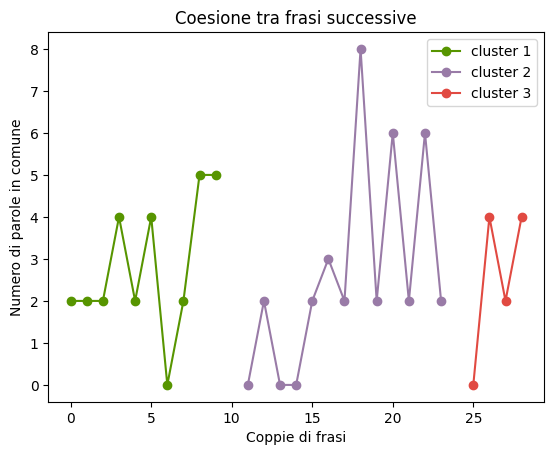

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5}, {(11, 12): 0, (12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2}, {(25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [11, 25, 30]
N. PAROLE MEDIE PER CLUSTER 0.8333333333333334


LISTE DI MINIMI:  {0: ([(6, 7)], 0, True), 1: ([(11, 12), (13, 14), (14, 15)], 0, True), 2: ([(25, 26)], 0, True)}
a 0 >  0
a.2
1.b 1 0
j:  0 - [7]
a 0 >  0
a.2
1.b 3 2
j:  1 - [7, 15]
NEW BREAKPOINTS:  [7, 15, 30]


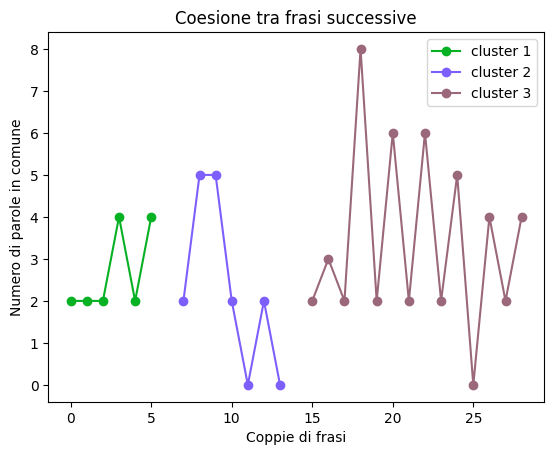

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4}, {(7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0, (12, 13): 2, (13, 14): 0}, {(15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [7, 15, 30]
N. PAROLE MEDIE PER CLUSTER 1.1428571428571428


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3), (4, 5)], 2, True), 1: ([(11, 12), (13, 14)], 0, True), 2: ([(25, 26)], 0, True)}
a 2 >  0
a.1
1.a 2 1
j:  0 - [13]
c
3 1 0
j:  1 - [13, 25]
NEW BREAKPOINTS:  [13, 25, 30]


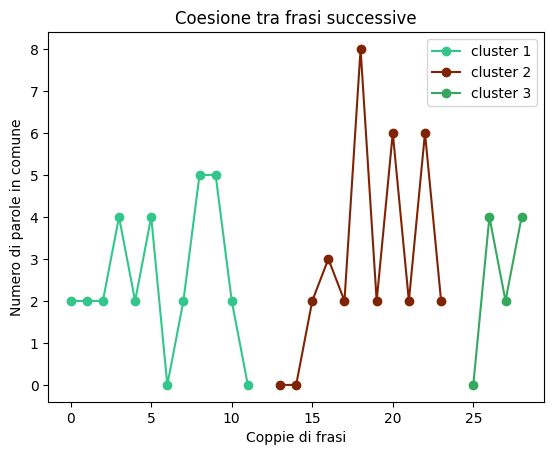

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0}, {(13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2}, {(25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [13, 25, 30]
N. PAROLE MEDIE PER CLUSTER 0.8333333333333334


LISTE DI MINIMI:  {0: ([(6, 7), (11, 12)], 0, True), 1: ([(13, 14), (14, 15)], 0, True), 2: ([(25, 26)], 0, True)}
a 0 >  0
a.2
1.b 2 0
j:  0 - [7]
a 0 >  0
a.2
1.b 2 1
j:  1 - [7, 15]
NEW BREAKPOINTS:  [7, 15, 30]


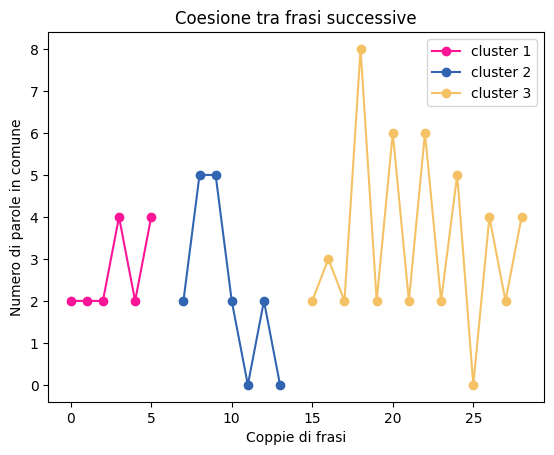

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4}, {(7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0, (12, 13): 2, (13, 14): 0}, {(15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [7, 15, 30]
N. PAROLE MEDIE PER CLUSTER 1.1428571428571428


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3), (4, 5)], 2, True), 1: ([(11, 12), (13, 14)], 0, True), 2: ([(25, 26)], 0, True)}
a 2 >  0
a.1
1.a 2 0
j:  0 - [11]
c
3 1 0
j:  1 - [11, 25]
NEW BREAKPOINTS:  [11, 25, 30]


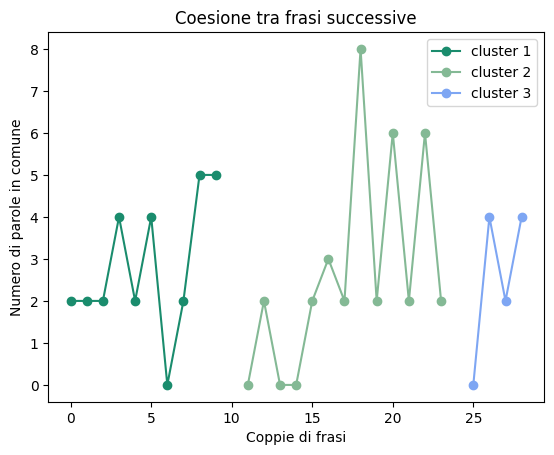

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5}, {(11, 12): 0, (12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2}, {(25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [11, 25, 30]
N. PAROLE MEDIE PER CLUSTER 0.8333333333333334


LISTE DI MINIMI:  {0: ([(6, 7)], 0, True), 1: ([(11, 12), (13, 14), (14, 15)], 0, True), 2: ([(25, 26)], 0, True)}
a 0 >  0
a.2
1.b 1 0
j:  0 - [7]
a 0 >  0
a.2
1.b 3 0
j:  1 - [7, 12]
NEW BREAKPOINTS:  [7, 12, 30]


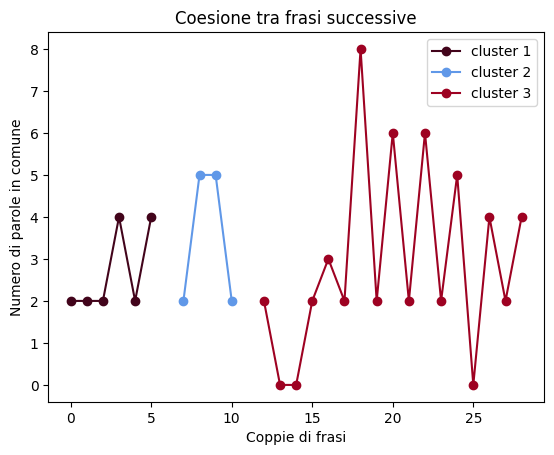

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4}, {(7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2}, {(12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [7, 12, 30]
N. PAROLE MEDIE PER CLUSTER 0.9803921568627452


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3), (4, 5)], 2, True), 1: ([(7, 8), (10, 11)], 2, True), 2: ([(13, 14), (14, 15), (25, 26)], 0, True)}
a 2 >  2
a.2
1.b 4 1
j:  0 - [2]
a 2 >  0
a.1
1.a 3 0
j:  1 - [2, 13]
NEW BREAKPOINTS:  [2, 13, 30]


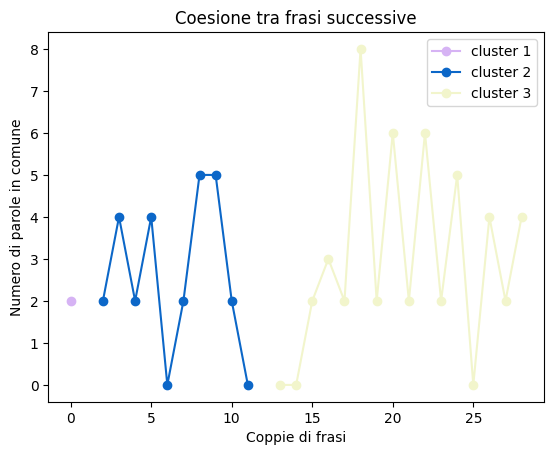

COESIONE:  [{(0, 1): 2}, {(2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0}, {(13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [2, 13, 30]
N. PAROLE MEDIE PER CLUSTER 1.0


ATTENZIONE: cluster con meno di 2 frasi
LISTE DI MINIMI:  {0: ([(0, 1)], 2, False), 1: ([(6, 7), (11, 12)], 0, True), 2: ([(13, 14), (14, 15), (25, 26)], 0, True)}
c
3 2 1
j:  0 - [11]
c
3 3 2
j:  1 - [11, 25]
NEW BREAKPOINTS:  [11, 25, 30]


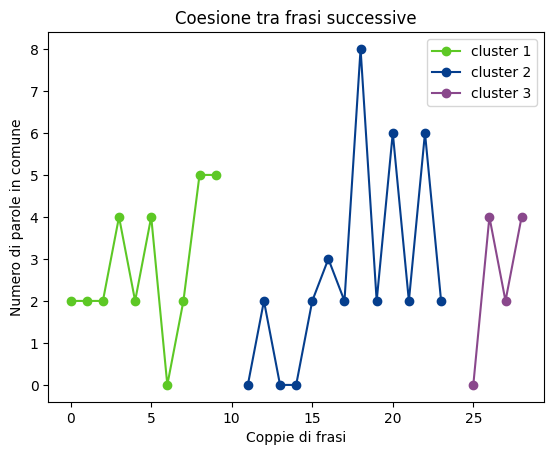

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5}, {(11, 12): 0, (12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2}, {(25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [11, 25, 30]
N. PAROLE MEDIE PER CLUSTER 0.8333333333333334


LISTE DI MINIMI:  {0: ([(6, 7)], 0, True), 1: ([(11, 12), (13, 14), (14, 15)], 0, True), 2: ([(25, 26)], 0, True)}
a 0 >  0
a.2
1.b 1 0
j:  0 - [7]
a 0 >  0
a.2
1.b 3 1
j:  1 - [7, 14]
NEW BREAKPOINTS:  [7, 14, 30]


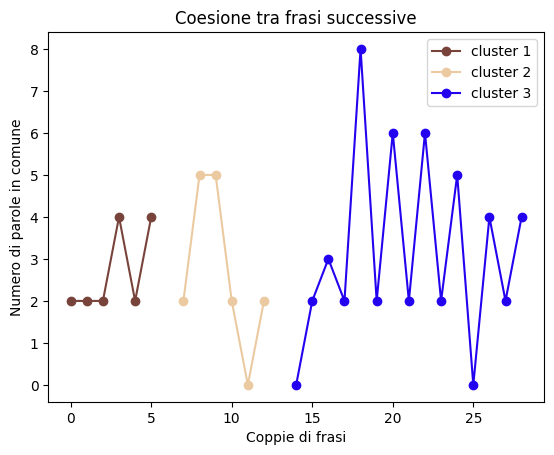

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4}, {(7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0, (12, 13): 2}, {(14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [7, 14, 30]
N. PAROLE MEDIE PER CLUSTER 1.0666666666666667


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3), (4, 5)], 2, True), 1: ([(11, 12)], 0, True), 2: ([(14, 15), (25, 26)], 0, True)}
a 2 >  0
a.1
1.a 1 0
j:  0 - [11]
c
3 2 0
j:  1 - [11, 14]
NEW BREAKPOINTS:  [11, 14, 30]


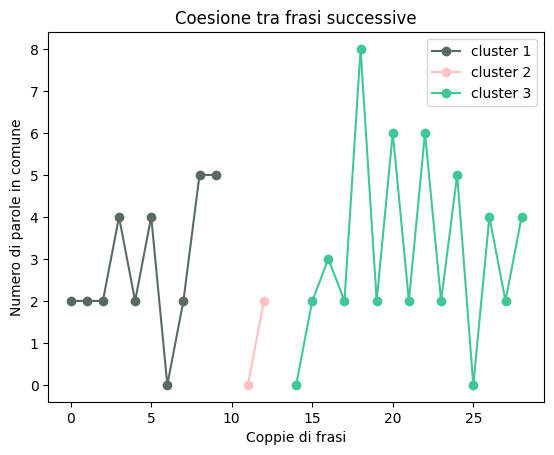

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5}, {(11, 12): 0, (12, 13): 2}, {(14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [11, 14, 30]
N. PAROLE MEDIE PER CLUSTER 1.0666666666666667


LISTE DI MINIMI:  {0: ([(6, 7)], 0, True), 1: ([(11, 12)], 0, True), 2: ([(14, 15), (25, 26)], 0, True)}
a 0 >  0
a.2
1.b 1 0
j:  0 - [7]
a 0 >  0
a.2
1.b 1 0
j:  1 - [7, 12]
NEW BREAKPOINTS:  [7, 12, 30]


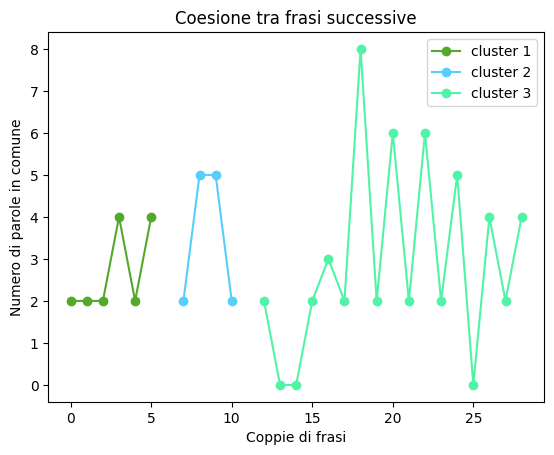

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4}, {(7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2}, {(12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [7, 12, 30]
N. PAROLE MEDIE PER CLUSTER 0.9803921568627452


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3), (4, 5)], 2, True), 1: ([(7, 8), (10, 11)], 2, True), 2: ([(13, 14), (14, 15), (25, 26)], 0, True)}
a 2 >  2
a.2
1.b 4 3
j:  0 - [5]
a 2 >  0
a.1
1.a 3 2
j:  1 - [5, 25]
NEW BREAKPOINTS:  [5, 25, 30]


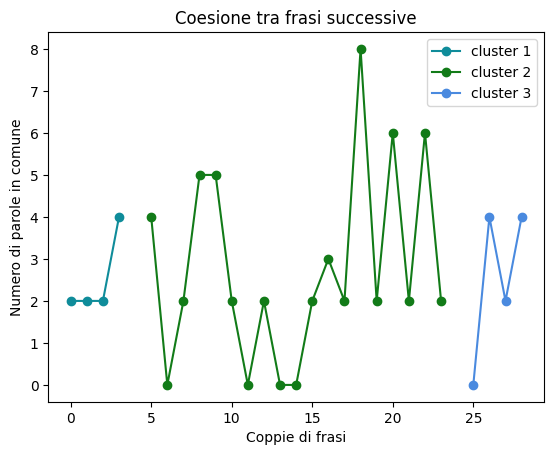

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4}, {(5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0, (12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2}, {(25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [5, 25, 30]
N. PAROLE MEDIE PER CLUSTER 0.8333333333333334


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3)], 2, True), 1: ([(6, 7), (11, 12), (13, 14), (14, 15)], 0, True), 2: ([(25, 26)], 0, True)}
a 2 >  0
a.1
1.a 4 3
j:  0 - [14]
c
3 1 0
j:  1 - [14, 25]
NEW BREAKPOINTS:  [14, 25, 30]


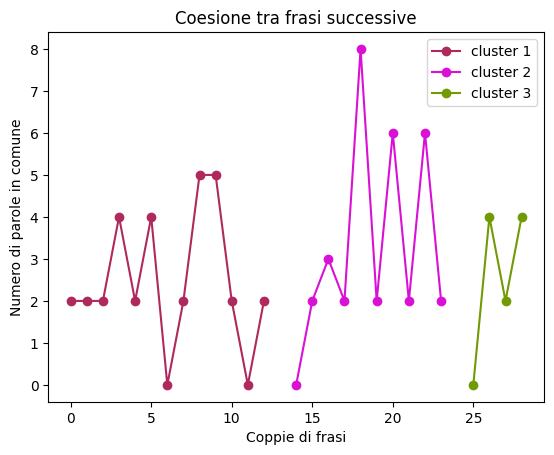

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0, (12, 13): 2}, {(14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2}, {(25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [14, 25, 30]
N. PAROLE MEDIE PER CLUSTER 0.8333333333333334


LISTE DI MINIMI:  {0: ([(6, 7), (11, 12)], 0, True), 1: ([(14, 15)], 0, True), 2: ([(25, 26)], 0, True)}
a 0 >  0
a.2
1.b 2 1
j:  0 - [12]
a 0 >  0
a.2
1.b 1 0
j:  1 - [12, 15]
NEW BREAKPOINTS:  [12, 15, 30]


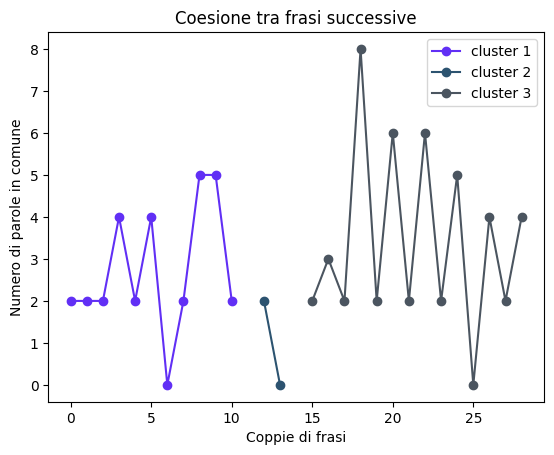

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2}, {(12, 13): 2, (13, 14): 0}, {(15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [12, 15, 30]
N. PAROLE MEDIE PER CLUSTER 1.1428571428571428


LISTE DI MINIMI:  {0: ([(6, 7)], 0, True), 1: ([(13, 14)], 0, True), 2: ([(25, 26)], 0, True)}
a 0 >  0
a.2
1.b 1 0
j:  0 - [7]
a 0 >  0
a.2
1.b 1 0
j:  1 - [7, 14]
NEW BREAKPOINTS:  [7, 14, 30]


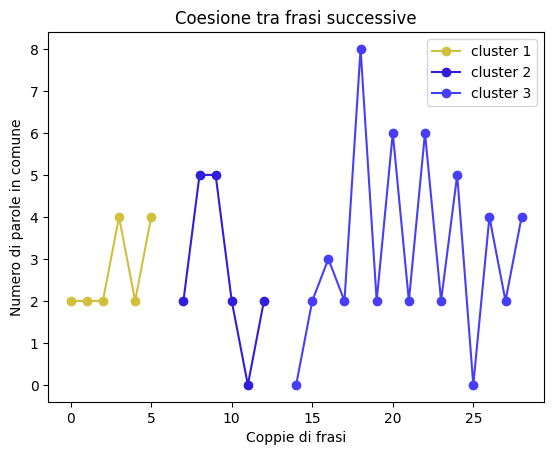

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4}, {(7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2, (11, 12): 0, (12, 13): 2}, {(14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [7, 14, 30]
N. PAROLE MEDIE PER CLUSTER 1.0666666666666667


LISTE DI MINIMI:  {0: ([(0, 1), (1, 2), (2, 3), (4, 5)], 2, True), 1: ([(11, 12)], 0, True), 2: ([(14, 15), (25, 26)], 0, True)}
a 2 >  0
a.1
1.a 1 0
j:  0 - [11]
c
3 2 0
j:  1 - [11, 14]
NEW BREAKPOINTS:  [11, 14, 30]


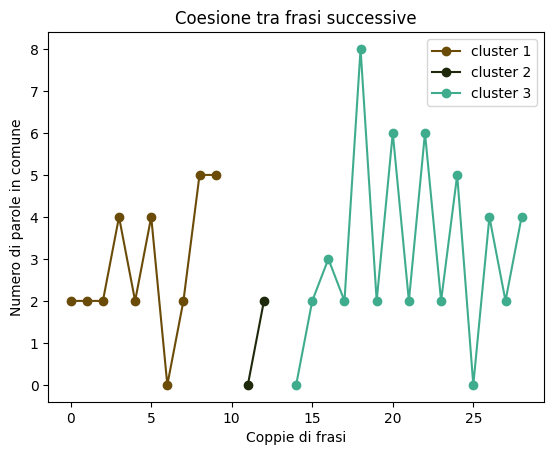

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4, (6, 7): 0, (7, 8): 2, (8, 9): 5, (9, 10): 5}, {(11, 12): 0, (12, 13): 2}, {(14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [11, 14, 30]
N. PAROLE MEDIE PER CLUSTER 1.0666666666666667


LISTE DI MINIMI:  {0: ([(6, 7)], 0, True), 1: ([(11, 12)], 0, True), 2: ([(14, 15), (25, 26)], 0, True)}
a 0 >  0
a.2
1.b 1 0
j:  0 - [7]
a 0 >  0
a.2
1.b 1 0
j:  1 - [7, 12]
NEW BREAKPOINTS:  [7, 12, 30]


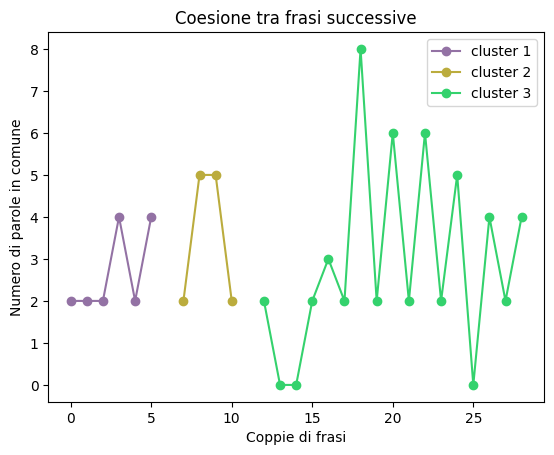

COESIONE:  [{(0, 1): 2, (1, 2): 2, (2, 3): 2, (3, 4): 4, (4, 5): 2, (5, 6): 4}, {(7, 8): 2, (8, 9): 5, (9, 10): 5, (10, 11): 2}, {(12, 13): 2, (13, 14): 0, (14, 15): 0, (15, 16): 2, (16, 17): 3, (17, 18): 2, (18, 19): 8, (19, 20): 2, (20, 21): 6, (21, 22): 2, (22, 23): 6, (23, 24): 2, (24, 25): 5, (25, 26): 0, (26, 27): 4, (27, 28): 2, (28, 29): 4}]
BREAKPOINTS:  [7, 12, 30]
N. PAROLE MEDIE PER CLUSTER 0.9803921568627452




In [43]:
for i in range(20):
    contenitore.search_new_breakpoints()
    print('\n')

BEST BREAKPOINTS: [10, 20, 30]
EVALUATION:  1.1481481481481481


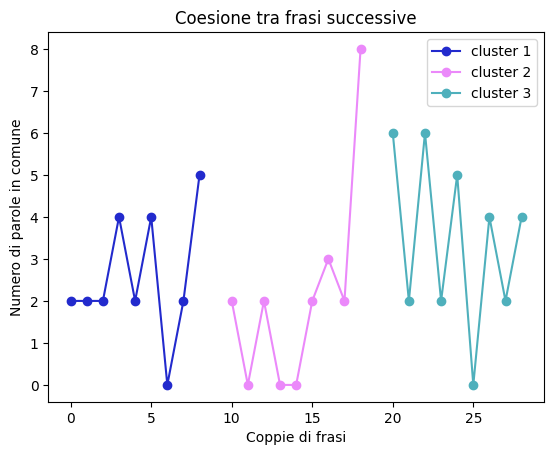

In [44]:
print('BEST BREAKPOINTS:', contenitore.best_breakpoints)
print('EVALUATION: ', contenitore.best_evaluation)
contenitore.plot_coehesion_values(best=True)